<a href="https://colab.research.google.com/github/Harsh-KH-6/Phising-Detection-Project/blob/main/phising_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Data handling
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Plotting
import matplotlib.pyplot as plt

# Optional: XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False

print("XGBoost available:", XGBOOST_AVAILABLE)


XGBoost available: True


In [9]:
import io
import pandas as pd
from google.colab import files

# Upload CSV manually
uploaded = files.upload()  # Select your CSV

# Use the correct key from uploaded dictionary
filename = list(uploaded.keys())[0]  # automatically takes the first uploaded file
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Show dataset info
print("Dataset shape:", df.shape)
print(df.columns.tolist())
print(df.head())

# Check for missing values
print(df.isnull().sum())


Saving dataset_phishing.csv to dataset_phishing (2).csv
Dataset shape: (11430, 89)
['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_hyperlinks', 'rat

In [13]:
from sklearn.preprocessing import StandardScaler

# Label column
label_col = 'status'
print("Detected label column:", label_col)

# Convert labels: 'legitimate' -> 0, 'phishing' -> 1
df[label_col] = df[label_col].map({'legitimate': 0, 'phishing': 1})

# Separate features and labels
X = df.drop([label_col, 'url'], axis=1)  # Drop label and URL column
y = df[label_col]

# Convert non-numeric columns to numeric if any
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill missing values with 0
X = X.fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Preprocessing complete. Features shape:", X_scaled.shape, "Labels shape:", y.shape)


Detected label column: status
Preprocessing complete. Features shape: (11430, 87) Labels shape: (11430,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (8001, 87) Test shape: (3429, 87)


In [18]:
results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]
results['Logistic Regression'] = {'model': lr, 'y_pred': y_pred_lr, 'y_prob': y_prob_lr}

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]
results['Random Forest'] = {'model': rf, 'y_pred': y_pred_rf, 'y_prob': y_prob_rf}

# XGBoost (if available)
if XGBOOST_AVAILABLE:
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_clf.fit(X_train, y_train)
    y_pred_xgb = xgb_clf.predict(X_test)
    y_prob_xgb = xgb_clf.predict_proba(X_test)[:,1]
    results['XGBoost'] = {'model': xgb_clf, 'y_pred': y_pred_xgb, 'y_prob': y_prob_xgb}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:10:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
def evaluate_model(name, y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1-score:", round(f1,4))
    if auc:
        print("ROC AUC:", round(auc,4))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    return {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'auc':auc}

metrics_table = {}
for name, data in results.items():
    metrics = evaluate_model(name, y_test, data['y_pred'], data.get('y_prob'))
    metrics_table[name] = metrics



=== Logistic Regression ===
Accuracy: 0.9402
Precision: 0.9425
Recall: 0.9376
F1-score: 0.94
ROC AUC: 0.9842

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1715
           1       0.94      0.94      0.94      1714

    accuracy                           0.94      3429
   macro avg       0.94      0.94      0.94      3429
weighted avg       0.94      0.94      0.94      3429


=== Random Forest ===
Accuracy: 0.965
Precision: 0.9628
Recall: 0.9673
F1-score: 0.9651
ROC AUC: 0.993

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1715
           1       0.96      0.97      0.97      1714

    accuracy                           0.97      3429
   macro avg       0.97      0.97      0.97      3429
weighted avg       0.97      0.97      0.97      3429


=== XGBoost ===
Accuracy: 0.9665
Precision: 0.9624
Recall: 0.9708
F1-score: 0.966

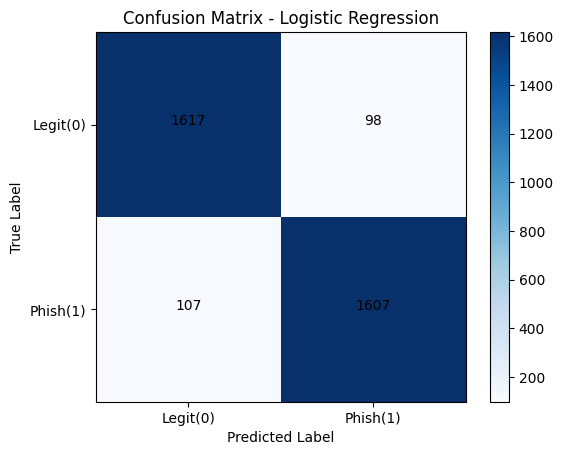

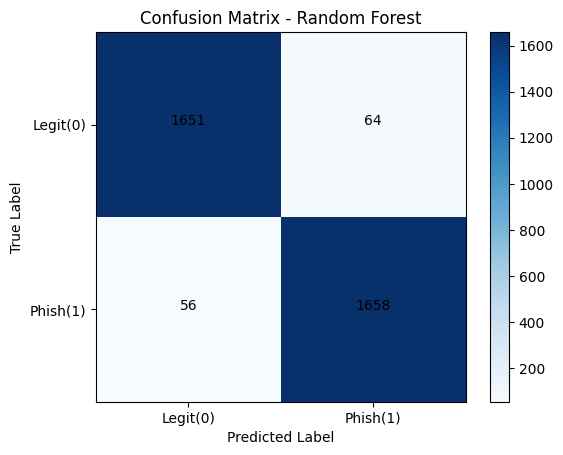

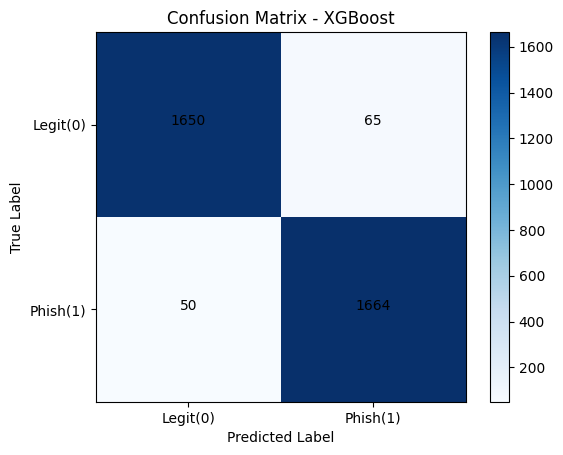

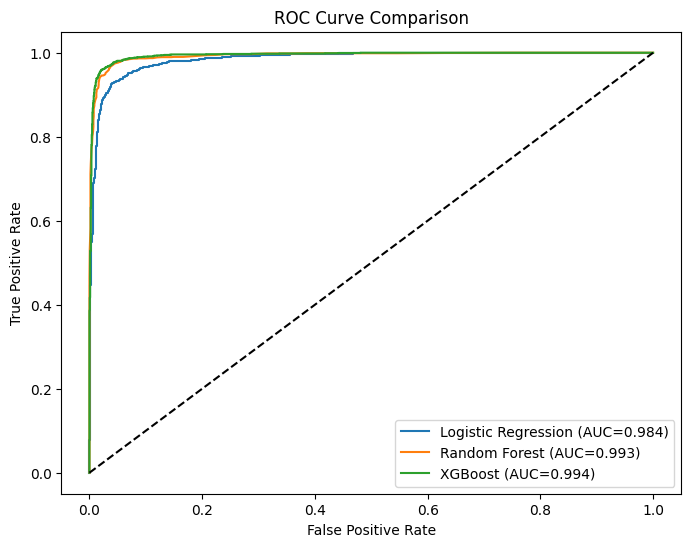

In [20]:
# Confusion Matrix
for name, data in results.items():
    cm = confusion_matrix(y_test, data['y_pred'])
    plt.figure()
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0,1], ['Legit(0)', 'Phish(1)'])
    plt.yticks([0,1], ['Legit(0)', 'Phish(1)'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', color='black')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# ROC Curve
plt.figure(figsize=(8,6))
for name, data in results.items():
    if data.get('y_prob') is not None:
        fpr, tpr, _ = roc_curve(y_test, data['y_prob'])
        auc = roc_auc_score(y_test, data['y_prob'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [21]:
# Select top 15 features
k = 15
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support(indices=True)]
print("Top features:", selected_features.tolist())

# Retrain Random Forest on selected features
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y, test_size=0.3, random_state=42, stratify=y)
rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf2.fit(X_train2, y_train2)
y_pred_rf2 = rf2.predict(X_test2)
y_prob_rf2 = rf2.predict_proba(X_test2)[:,1]
print("\nEvaluation after feature selection:")
evaluate_model('Random Forest (Top 15 Features)', y_test2, y_pred_rf2, y_prob_rf2)



/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 59 61 63 68 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Top features: ['length_url', 'length_hostname', 'ip', 'nb_qm', 'nb_eq', 'nb_slash', 'nb_www', 'ratio_digits_url', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks', 'domain_in_title', 'domain_age', 'google_index', 'page_rank']

Evaluation after feature selection:

=== Random Forest (Top 15 Features) ===
Accuracy: 0.9589
Precision: 0.9538
Recall: 0.9644
F1-score: 0.9591
ROC AUC: 0.9917

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1715
           1       0.95      0.96      0.96      1714

    accuracy                           0.96      3429
   macro avg       0.96      0.96      0.96      3429
weighted avg       0.96      0.96      0.96      3429



{'accuracy': 0.9588801399825022,
 'precision': 0.9538372763993076,
 'recall': 0.9644107351225204,
 'f1': 0.959094865100087,
 'auc': np.float64(0.9917129045317077)}

In [22]:
# Save metrics summary
metrics_df = pd.DataFrame(metrics_table).T
metrics_df.to_csv('model_metrics_summary.csv', index=True)

# Save selected features
pd.Series(selected_features).to_csv('selected_features.csv', index=False)
print("Saved metrics and features CSVs")



Saved metrics and features CSVs
